<a href="https://colab.research.google.com/github/javahedi/QuantumStateTomography-ML/blob/main/main_last.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [102]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import os
import glob

In [103]:
# Check available devices
devices = tf.config.experimental.list_physical_devices('GPU')  # Check for GPU
if devices:
    print("Using GPU")
    tf.config.experimental.set_visible_devices(devices[0], 'GPU')  # Use the first GPU
else:
    print("Using CPU")

Using GPU


In [104]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [105]:
path         = "/content/drive/MyDrive/SL_data/"
cvs_names    = glob.glob(f'{path}*.csv')
bank_names   = glob.glob(f'{path}*bank.npy')
weight_names = glob.glob(f'{path}*weights.npy')

angles_list  = []
banks_list   = []
weights_list = []
for id, name in enumerate(cvs_names):
    data    = np.loadtxt( os.path.join(path,cvs_names[id]),delimiter=',',skiprows=1)
    bank    = np.load(bank_names[id],mmap_mode="r")
    weights = np.load(weight_names[id],mmap_mode="r")

    angles_list.append(data)
    banks_list.append(bank[1:])
    weights_list.append(weights[1:])


angles_data   = np.stack(angles_list)
banks_data    = np.stack(banks_list)
weights_data  = np.stack(weights_list)

angles_data[:,:,0] = np.sin(angles_data[:,:,0])
angles_data[:,:,1] = np.sin(angles_data[:,:,1]/4.0)

angles_data[:,:,-2] = np.sin(angles_data[:,:,-2])
angles_data[:,:,-1] = np.sin(angles_data[:,:,-1]/4.0)


print(angles_data.shape)
print(banks_data.shape)
print(weights_data.shape)

(1000, 99, 5)
(1000, 99, 100, 2, 2)
(1000, 99, 100)


In [106]:
X,y=angles_data[:,:,:3],angles_data[:,:,3:]

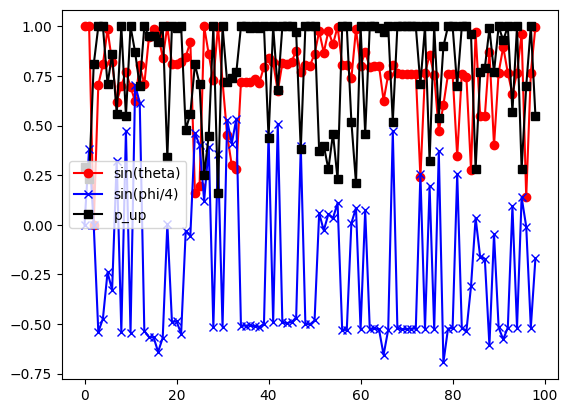

In [107]:
plt.plot(X[1,:,0],'o-r',label='sin(theta)')
plt.plot(X[1,:,1],'x-b',label='sin(phi/4)')
plt.plot(X[1,:,2],'s-k',label='p_up')
plt.legend()
plt.show()

In [108]:
valid_split = 0.2

num_valid_samples = int(angles_data.shape[0] * valid_split)

# Split the data into training and validation sets
train_data_angles  = angles_data[:-num_valid_samples]
train_data_banks   = banks_data[:-num_valid_samples]
train_data_weights = weights_data[:-num_valid_samples]

valid_data_angles  = angles_data[-num_valid_samples:]
valid_data_banks   = banks_data[-num_valid_samples:]
valid_data_weights = weights_data[-num_valid_samples:]

In [109]:
train_data_angles.shape

(800, 99, 5)

In [110]:
# Set batch size
batch_size = 64

# TensorFlow datasets API
train_dataset = tf.data.Dataset.from_tensor_slices((train_data_angles, train_data_banks, train_data_weights)).batch(batch_size, drop_remainder=True)
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_data_angles, valid_data_banks, valid_data_weights)).batch(batch_size, drop_remainder=True)


In [111]:
#Get the size of the dataset
dataset_size = tf.data.experimental.cardinality(train_dataset).numpy()

# Print the size of the dataset
print("Dataset Size:", dataset_size)

total_data_points = dataset_size * batch_size
print("Total Data Points:", total_data_points)

Dataset Size: 12
Total Data Points: 768


In [112]:

# Custom Self-Attention Layer
class SelfAttention(tf.keras.layers.Layer):
    '''
      arXiv:1706.03762v7   ---> Scaled Dot-Product Attention
      Input Shape: (batch_size, sequence_length, feature_dim)

      batch_size     : The number of samples in each batch.
      sequence_length: The length of the sequence in each sample.
      feature_dim    : The number of features in each element of the sequence.

      Output Shape: (batch_size, sequence_length, feature_dim)

          The output preserves the same structure as the input.
          For each element in the sequence, the self-attention mechanism computes a
          weighted sum of all elements in the sequence based on their relationships,
          and the output at each position is a combination of these weighted sums.
    '''

    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.w_q = self.add_weight(name="w_q", shape=(input_shape[-1], input_shape[-1]), initializer="uniform", trainable=True)
        self.w_k = self.add_weight(name="w_k", shape=(input_shape[-1], input_shape[-1]), initializer="uniform", trainable=True)
        super(SelfAttention, self).build(input_shape)

    def call(self, x):
        q = tf.matmul(x, self.w_q)
        k = tf.matmul(x, self.w_k)
        v = x
        attention_scores = tf.matmul(q, k, transpose_b=True)
        attention_scores = tf.nn.softmax(attention_scores, axis=-1)
        output = tf.matmul(attention_scores, v)
        return output

In [113]:

class InfoGain_vectorized(tf.Module):
    def __init__(self):
        super(InfoGain_vectorized, self).__init__()

    def information_gain(self, angles, bank_particles, weights):
        result = tf.numpy_function(self.information_gain_py, [angles, bank_particles, weights], tf.float64)
        return tf.convert_to_tensor(result, dtype=tf.float64)

    def information_gain_py(self, angles,bank_particles,weights):

        best_guess=np.array(np.einsum('ijkl,ij->ikl',bank_particles,weights))
        return self.adaptive_cost_func(angles,bank_particles,weights,best_guess)

    def adaptive_cost_func(self, angles,rhoBank,weights,bestGuess):

        # Crates projector from angles
        povm=self.angles_to_single_qubit_POVM(angles)
        # Computes the entropy of prior and posterior distributions. See 10.1103/PhysRevA.85.052120 for more details.
        K=self.Shannon_entropy(np.einsum('nijk,nkj->ni',povm,bestGuess))
        J=self.Shannon_entropy(np.einsum('nijk,nlkj->nil',povm,rhoBank))
        # Returns the negative values such that it becomes a minimization problem rather than maximization problem.
        return np.real(K-np.einsum("ij,ij->i",J,weights))

    #def Shannon_entropy(self, prob):
    #    return np.real(np.sum(-(prob*np.log2(prob)),axis=1))

    def Shannon_entropy(self, prob):
        epsilon = 1e-10  # Small epsilon value to avoid division by zero
        prob    = np.maximum(prob, epsilon)  # Replace zeros with epsilon
        return np.real(np.sum(-(prob * np.log2(prob)), axis=1))

    def angles_to_single_qubit_POVM(self, angles):
        """
        Function is now vectorized in 0th index.
        Takes in measurement angles as dictionaries and returns the spin POVM as 2x2x2 complex array .
        For single qubit only.
        """
        up_state_vector=np.array([np.cos(angles[:,0]/2),np.exp(1j*angles[:,1])*np.sin(angles[:,0]/2)],dtype=complex)
        up_POVM=np.einsum("in,jn->nij",up_state_vector,up_state_vector.conj())
        return np.einsum('injk->nijk',np.array([up_POVM[:],np.eye(2)-up_POVM[:]],dtype=complex))

In [114]:
def custom_loss(y_true, y_pred, bank_particles, weights, lambda_weight=1.0, replace_inf_value=100):

    info_gain = InfoGain_vectorized()

    mse_target = tf.keras.losses.mean_squared_error(y_true, y_pred)

    true_info_gains = [info_gain.information_gain(y_true[:, i, :], bank_particles[:, i, ...], weights[:, i]) for i in range(y_true.shape[1])]
    pred_info_gains = [info_gain.information_gain(y_pred[:, i, :], bank_particles[:, i, ...], weights[:, i]) for i in range(y_true.shape[1])]

    true_info_gains = tf.convert_to_tensor(true_info_gains, dtype=tf.float64)
    pred_info_gains = tf.convert_to_tensor(pred_info_gains, dtype=tf.float64)


    loss_infoGain = 1e4 * tf.math.abs(pred_info_gains - true_info_gains)
    # Check for infinity in the total_loss tensor
    loss_infoGain = tf.where(tf.math.is_finite(loss_infoGain), loss_infoGain, replace_inf_value)

    total_loss = (1.0 - lambda_weight) * tf.reduce_mean(mse_target) + lambda_weight * tf.reduce_mean(loss_infoGain)

    return total_loss



In [115]:
info_gain = InfoGain_vectorized()

#tf.random.set_seed(42)
for batch_angles, batch_banks, batch_weights in train_dataset.take(1):
      # Separate input (X) and true labels (y)
      y_true = batch_angles[:, :, :2]


# Training dataset
for batch_index, (batch_angles, batch_banks, batch_weights) in enumerate(train_dataset):
      #print(f"Batch Index: {batch_index}")
      # Separate input (X) and true labels (y)
      y_pred = batch_angles[:, :, :2]

      #noise  = tf.random.normal(shape=tf.shape(y_true), mean=5.0, stddev=0.1, dtype=tf.float64)
      #y_pred = y_true + noise
      mse    = tf.keras.losses.mean_squared_error(y_true, y_pred)


      true_info_gains = [info_gain.information_gain(y_true[:, i, :], batch_banks[:, i, ...], batch_weights[:, i]) for i in range(y_true.shape[1])]
      pred_info_gains = [info_gain.information_gain(y_pred[:, i, :], batch_banks[:, i, ...], batch_weights[:, i]) for i in range(y_true.shape[1])]

      true_info_gains = tf.convert_to_tensor(true_info_gains, dtype=tf.float64)
      pred_info_gains = tf.convert_to_tensor(pred_info_gains, dtype=tf.float64)



      loss_infoGain_v1 =  tf.math.log(pred_info_gains / true_info_gains)
      loss_infoGain_v2 = 1e4 * tf.math.abs(pred_info_gains - true_info_gains)
      loss_infoGain_v3 = 1e5 * pred_info_gains**2 - true_info_gains**2

      # Check for infinity in the total_loss tensor
      #loss_infoGain = tf.where(tf.math.is_finite(loss_infoGain), loss_infoGain, 100)
      #print(tf.shape(true_info_gains),' ',tf.shape(loss_infoGain))
      print(f'{batch_index}, {tf.reduce_mean(mse).numpy():3.4f}', ' ### ',
            f'{tf.reduce_mean(loss_infoGain_v1).numpy():2.6f}', ' ### ',
            f'{tf.reduce_mean(loss_infoGain_v2).numpy():2.6f}', ' ### ',
            f'{tf.reduce_mean(loss_infoGain_v3).numpy():2.6f}')





0, 0.0000  ###  0.000000  ###  0.000000  ###  0.159300
1, 0.2382  ###  0.017100  ###  0.451527  ###  0.154807
2, 0.2357  ###  0.009897  ###  0.433843  ###  0.168023
3, 0.2343  ###  0.010725  ###  0.419749  ###  0.163509
4, 0.2336  ###  0.011202  ###  0.427121  ###  0.176404
5, 0.2364  ###  0.009288  ###  0.452669  ###  0.173871
6, 0.2517  ###  0.017470  ###  0.495115  ###  0.158257
7, 0.2533  ###  0.011998  ###  0.509910  ###  0.176284
8, 0.2436  ###  0.011129  ###  0.440363  ###  0.167799
9, 0.2287  ###  0.010087  ###  0.453298  ###  0.175711
10, 0.2503  ###  0.015667  ###  0.437038  ###  0.169825
11, 0.2404  ###  0.008588  ###  0.395139  ###  0.164461


In [116]:
def custom_accuracy(y_true, y_pred):
    #  Mean Absolute Error
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))
    return mae

In [117]:
num_samples = angles_data.shape[0]
data_size   = angles_data.shape[1]
input_size  = 3
output_size = 2

model = Sequential()
#model.add(Dense(32, input_shape=(data_size, input_size), activation='relu'))
model.add(Dense(32, input_shape=(None, input_size), activation='relu'))
model.add(Dense(64, activation='relu'))  # Additional hidden layer
model.add(SelfAttention())               # Scaled Dot-Product Attention with self-attention
model.add(Dense(output_size, activation='linear'))  # Linear activation for regression


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer='adam', loss=custom_loss)
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, None, 32)          128       
                                                                 
 dense_34 (Dense)            (None, None, 64)          2112      
                                                                 
 self_attention_11 (SelfAtt  (None, None, 64)          8192      
 ention)                                                         
                                                                 
 dense_35 (Dense)            (None, None, 2)           130       
                                                                 
Total params: 10562 (41.26 KB)
Trainable params: 10562 (41.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [118]:
test_data = np.random.rand(32, 10, 3)  # Assuming batch=32, sequence length=10, features=3

test_data_tf = tf.constant(test_data, dtype=tf.float32)

predictions = model.predict(test_data_tf)

print("Input Shape:", test_data.shape)
print("Output Shape:", predictions.shape)

1/1 [==============================] - 0s 70ms/step
Input Shape: (32, 10, 3)
Output Shape: (32, 10, 2)


In [119]:
class MyCustomModel(Model):
    def __init__(self, input_size, output_size):
        super(MyCustomModel, self).__init__()
        self.dense1 = Dense(32, activation='relu')
        self.dense2 = Dense(64, activation='relu')
        self.self_attention = SelfAttention()
        self.output_layer = Dense(output_size, activation='linear')

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.self_attention(x)
        return self.output_layer(x)

In [120]:
model2 = MyCustomModel(input_size=3, output_size=2)
model2.compile(optimizer=optimizer, loss=custom_loss)
#model2.summary()

In [121]:
checkpoint_path = "/content/drive/MyDrive/SL_data/model_checkpoint.h5"
early_stopping   = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)


In [122]:
train_loss_history = []
valid_loss_history = []
epochs             = 10

In [123]:
@tf.function(reduce_retracing=True)
def train_step(batch_angles, batch_banks, batch_weights):
    total_loss = 0

    with tf.GradientTape() as tape:
        X      = batch_angles[:, :, :3]
        y_true = batch_angles[:, :, 3:]

        y_predict = model(X)
        loss = custom_loss(y_predict, y_true, batch_banks, batch_weights)

    gradients = tape.gradient(loss, model.trainable_variables)
    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss


@tf.function(reduce_retracing=True)
def validate_step(batch_angles, batch_banks, batch_weights):
    X      = batch_angles[:, :, :3]
    y_true = batch_angles[:, :, 3:]

    y_predict = model(X)
    loss = custom_loss(y_predict, y_true, batch_banks, batch_weights)

    return loss


In [125]:
for epoch in range(epochs):

    total_train_loss = 0
    for batch_index, (batch_angles, batch_banks, batch_weights) in enumerate(train_dataset):
        print(f"Training Batch Index: {batch_index + 1} / {len(train_dataset)}", end='\r')
        loss = train_step(batch_angles, batch_banks, batch_weights)
        total_train_loss += loss.numpy()

    total_valid_loss = 0
    for batch_angles, batch_banks, batch_weights in valid_dataset:
        loss = validate_step(batch_angles, batch_banks, batch_weights)
        total_valid_loss += loss.numpy()

    avg_train_loss = total_train_loss / len(train_dataset)
    avg_valid_loss = total_valid_loss / len(valid_dataset)

    train_loss_history.append(avg_train_loss)
    valid_loss_history.append(avg_valid_loss)

    print(f'Epoch {epoch + 1}/{epochs}, '
          f'Training   Loss: {avg_train_loss:.6f}, '
          f'Validation Loss: {avg_valid_loss:.6f}, ')

    # Print additional information for debugging
    #print("True Values:", y_true[0].numpy())
    #print("Predicted Values:", model(X)[0].numpy())

    #Evaluate early stopping criteria
    #if early_stopping.on_epoch_end(epoch + 1, {'val_loss': avg_val_loss}):
    #    print("Early stopping triggered.")
    #    break

Epoch 1/10, Training   Loss: 0.920439, Validation Loss: 0.935443, 
Epoch 2/10, Training   Loss: 0.920439, Validation Loss: 0.935443, 
Epoch 3/10, Training   Loss: 0.920439, Validation Loss: 0.935443, 
Epoch 4/10, Training   Loss: 0.920439, Validation Loss: 0.935443, 
Epoch 5/10, Training   Loss: 0.920439, Validation Loss: 0.935443, 
Epoch 6/10, Training   Loss: 0.920439, Validation Loss: 0.935443, 
Epoch 7/10, Training   Loss: 0.920439, Validation Loss: 0.935443, 
Epoch 8/10, Training   Loss: 0.920439, Validation Loss: 0.935443, 
Epoch 9/10, Training   Loss: 0.920439, Validation Loss: 0.935443, 
Epoch 10/10, Training   Loss: 0.920439, Validation Loss: 0.935443, 


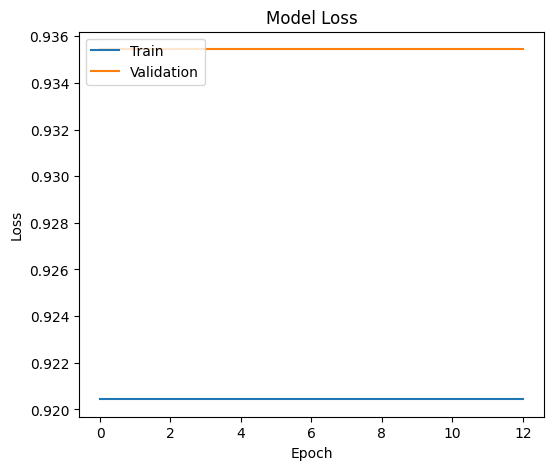

In [126]:
plt.figure(figsize=(6, 5))
plt.plot(train_loss_history)
plt.plot(valid_loss_history)
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Load the best model weights
#model.load_weights(checkpoint_path)

# Save the final model
#final_model_path = "/content/drive/MyDrive/SL_data/final_model.h5"
#model.save(final_model_path)